# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Import useful Libraries

In [365]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Section : Data Understanding
#### Gether data

In [366]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [13]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


10 events in total.

In [205]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


17k is the total number of users.

In [206]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### Assess Data

In [98]:
profile.isna().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [114]:
(~profile['gender'].isna() & profile['income'].isna()).sum()

0

From this we can tell that there is 12.8% of the users have NAN gender and NAN income at the same time. Which we might consider dropping them.

In [102]:
profile.duplicated().sum()

0

In [180]:
ids_na = profile[profile['gender'].isna()]['id']

<Axes: title={'center': 'Age Distribution'}>

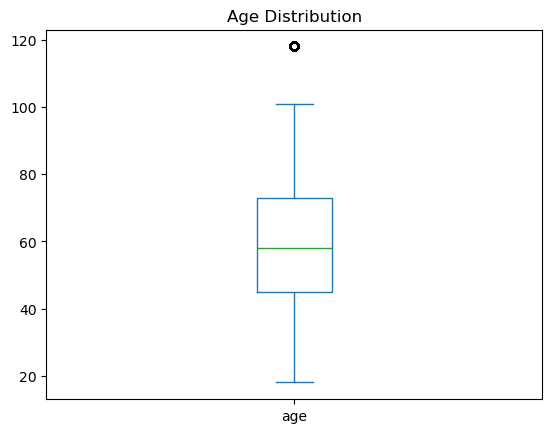

In [368]:
profile['age'].plot(kind='box', title = 'Age Distribution')

From the figure above we might assume that the oldest person that might use the app and receive offers would be 88 years old.

In [48]:
profile['age'].quantile(0.85)

88.0

<Axes: title={'center': 'Income Distribution'}>

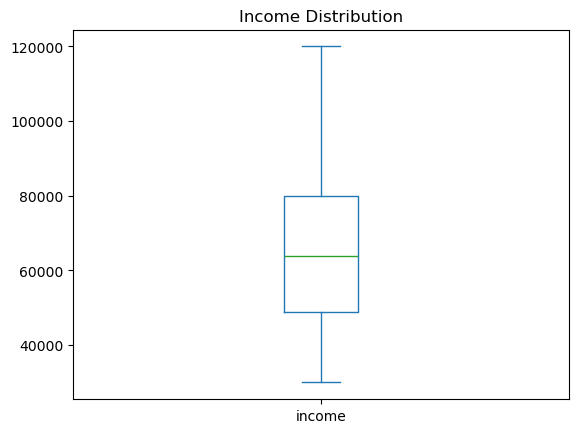

In [369]:
profile['income'].plot(kind = 'box', title = 'Income Distribution')

<Axes: title={'center': 'Genders'}, ylabel='count'>

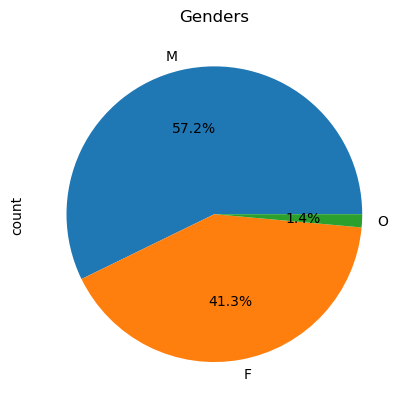

In [370]:
profile['gender'].dropna().value_counts().plot(kind= 'pie',autopct = '%1.1f%%', title = 'Genders')

In [371]:
# Checking Null values
transcript.isna().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [373]:
transcript[transcript['event']=='offer received']['value'].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [374]:
# Checking the unique events
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

<Axes: title={'center': 'Events'}, ylabel='count'>

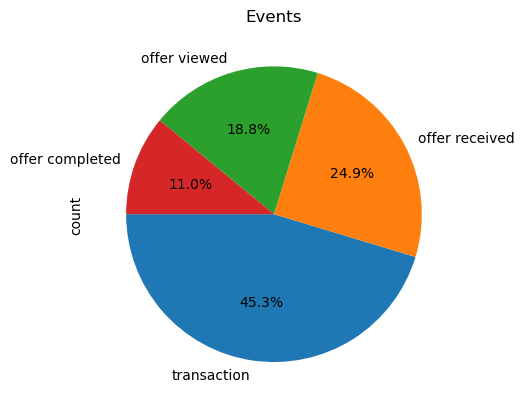

In [375]:
transcript['event'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=180, title = 'Events')

Almost **25%** of the events belongs to `offer received`, while the offers being viewed  `offer viewed` make up about **75%** of the total offers.

The good thing is that almost **45%** of the offers are being completed `offer completed`.

In [377]:
transcript[transcript['event'] == 'transaction']['person'].value_counts().sort_values(ascending = False).head(10)

person
79d9d4f86aca4bed9290350fb43817c2    36
8dbfa485249f409aa223a2130f40634a    36
94de646f7b6041228ca7dec82adb97d2    35
b1f4ece7d49342628a9ed77aee2cde58    32
5e60c6aa3b834e44b822ea43a3efea26    32
a42ed50acc4d4b25bca647c9e0b916ad    31
d0a80415b84c4df4908b8403b19765e3    30
ab25fd6fbd5040f880751921e4029757    30
40ce078d5b2a43d19138a788754520be    30
4142f5e23db741b1af4be0287dc91c1c    30
Name: count, dtype: int64

The highest number of transactions made by one person is **36**.

In [76]:
profile[profile['id'].isin(transcript[transcript['event'] == 'transaction']['person'].value_counts().sort_values(ascending = False).index[0:10])]

,gender,age,id,became_member_on,income
1485,M,37,b1f4ece7d49342628a9ed77aee2cde58,20180105,64000.0
3108,M,27,94de646f7b6041228ca7dec82adb97d2,20140126,33000.0
3953,F,62,a42ed50acc4d4b25bca647c9e0b916ad,20161017,33000.0
5978,M,53,d0a80415b84c4df4908b8403b19765e3,20160218,37000.0
6363,M,63,8dbfa485249f409aa223a2130f40634a,20151118,48000.0
6472,M,35,ab25fd6fbd5040f880751921e4029757,20150901,49000.0
6663,M,59,5e60c6aa3b834e44b822ea43a3efea26,20141120,55000.0
7672,M,61,40ce078d5b2a43d19138a788754520be,20160502,31000.0
10250,M,76,79d9d4f86aca4bed9290350fb43817c2,20150423,34000.0
11591,M,47,4142f5e23db741b1af4be0287dc91c1c,20171225,36000.0


The top 10 numbers of transactions, 9 of them were made by male users while 1 transaction only was made by a female one.

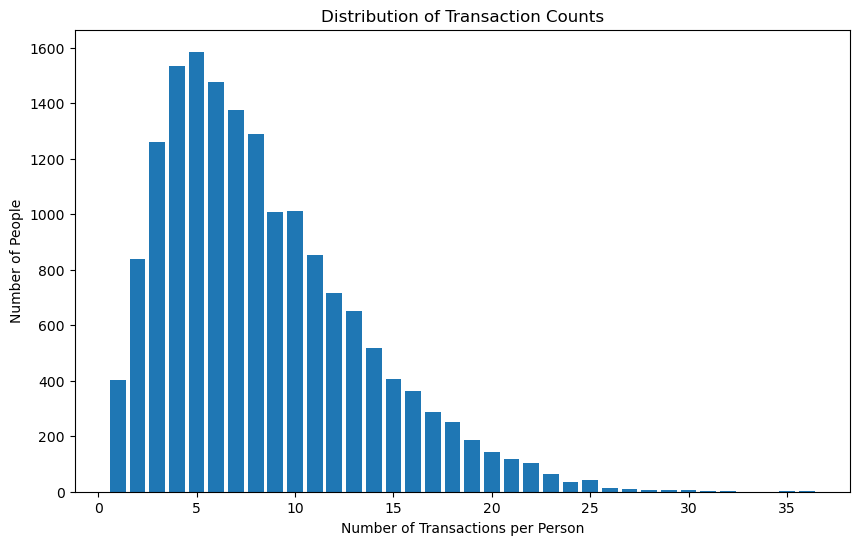

In [378]:
# Plotting the value_counts
value_counts = transcript[transcript['event'] == 'transaction']['person'].value_counts().sort_values(ascending=False).value_counts()
plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Number of Transactions per Person')
plt.ylabel('Number of People')
plt.title('Distribution of Transaction Counts')
plt.show()

In [162]:
value_counts.loc[range(1,4)].sum()/value_counts.sum()

0.15086258897333815

In [163]:
value_counts.loc[range(4,11)].sum()/value_counts.sum()

0.5600193026903124

In [166]:
# The +3 in the next line because there is no user with 33 or 34 transactions 
# However, there is 1 person with 35 and 2 with 36 transactions.
# So 3 added.
(value_counts.loc[range(11,33)].sum()+3)/value_counts.sum()

0.2891181083363494

Most Common Transaction Counts:

The highest frequency is for 5 transactions, suggesting that many users tend to perform around 5 transactions.
Similarly, the frequencies for 4, 6, and 7 transactions are also quite high.

User Engagement Segmentation:

Using this data to segment users based on their activity levels.

    For instance:
    Users making 1–3 transactions could be considered low-engagement users. 15%
    Users making 4–10 transactions could be medium-engagement. 56%
    Users making more than 10 transactions could be high-engagement users. 29%

More than half of users will belong to the medium-engagement segment.

In [322]:
# Let's find how many transactions that people with NAN values have done so far.
transcript[transcript['person'].isin(ids_na)]['event'].value_counts()

event
transaction        14996
offer received      9776
offer viewed        7865
offer completed     1135
Name: count, dtype: int64

<Axes: title={'center': 'Events portions but for people to be dropped'}, ylabel='count'>

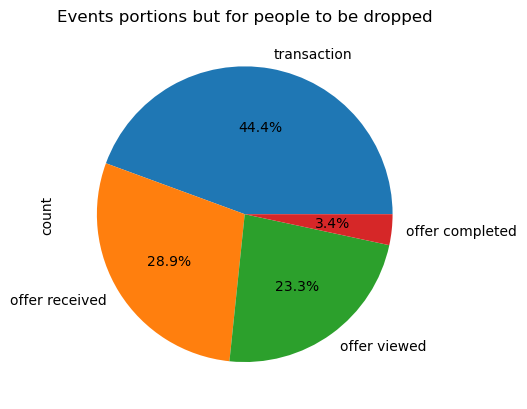

In [380]:
transcript[transcript['person'].isin(ids_na)]['event'].value_counts().plot(kind='pie',
                                                                           autopct = '%1.1f%%',
                                                                           title = 'Events portions but for people to be dropped')

In [177]:
# Let's find the portion of events that people with NAN values have done so far.
transcript[transcript['person'].isin(ids_na)]['event'].value_counts().sum()/transcript.shape[0]

0.11017374907840566

These people have completed less than **9%** of the received offers.

**11%** of the total events is not a small portions to ignor; however, as we are focusing on the offers only, we might consider dropping these people.

## Section : Data Preparation#### Data Cleaning


As noticed, we don't have these 118 years old people alive in the real world. which should be dropped.

Also, users with unknown income and gender, since we cannot make useful insights from `age`, `id`, and `become_member_on` columns only.

In [381]:
# First drop na
profile_clean = profile.copy() # intial copy
profile_clean.dropna(axis = 0, inplace = True)

#Drop these people events
transcript_clean = transcript.copy()# intial copy
transcript_clean = transcript_clean[~transcript_clean['person'].isin(ids_na)]


After dropping the NANs, let's drop the outliers as discussed before.

In [382]:
Q3 = profile_clean['age'].quantile(0.75)
Q1 = profile_clean['age'].quantile(0.25)
IQR = Q3 - Q1
highest_threshold = 1.5* IQR + Q3
highest_threshold

102.0

In [383]:
profile_clean = profile_clean[profile_clean['age'] < highest_threshold]
print(profile_clean.shape)
profile_clean.head()

(14825, 5)


,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


Seems like nothing happened here (*No dropped rows*), but at least now we are sure that there is no fake values so far.

In [384]:
print(transcript_clean.shape)
transcript_clean.head()

(272762, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [385]:
# Let's do some preprocessing on value column
# Assuming 'transcript_clean' is your original dataframe
# Normalize the 'value' column and rename columns for consistency
norma = pd.json_normalize(transcript_clean['value']).rename(columns={'offer id': 'offer_id_1', 'offer_id': 'offer_id_2'})

# Reset indices before concatenation to avoid misalignment
transcript_clean.reset_index(drop=True, inplace=True)
norma.reset_index(drop=True, inplace=True)

# Concatenate the original dataframe without the 'value' column with the normalized dataframe
both = pd.concat([transcript_clean.drop('value', axis=1), norma], axis=1)

# Create a single 'offer_id' column, using values from 'offer_id_1' and 'offer_id_2'
both['offer_id'] = both['offer_id_1'].combine_first(both['offer_id_2'])

# Drop the redundant columns
transcript_clean = both.drop(columns=['offer_id_1', 'offer_id_2'])
transcript_clean = transcript_clean.fillna(0)
print(transcript_clean.shape)
transcript_clean.head()

(272762, 6)


,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,0.0,0.0,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [386]:
transcript_clean[transcript_clean['event'] == 'offer completed'].value_counts('offer_id')

offer_id
fafdcd668e3743c1bb461111dcafc2a4    5003
2298d6c36e964ae4a3e7e9706d1fb8c2    4886
9b98b8c7a33c4b65b9aebfe6a799e6d9    4188
f19421c1d4aa40978ebb69ca19b0e20d    4103
2906b810c7d4411798c6938adc9daaa5    3911
ae264e3637204a6fb9bb56bc8210ddfd    3657
0b1e1539f2cc45b7b9fa7c272da2e1d7    3386
4d5c57ea9a6940dd891ad53e9dbe8da0    3310
Name: count, dtype: int64

Counting the completed events and mergeing them with the event table to get a better vision.

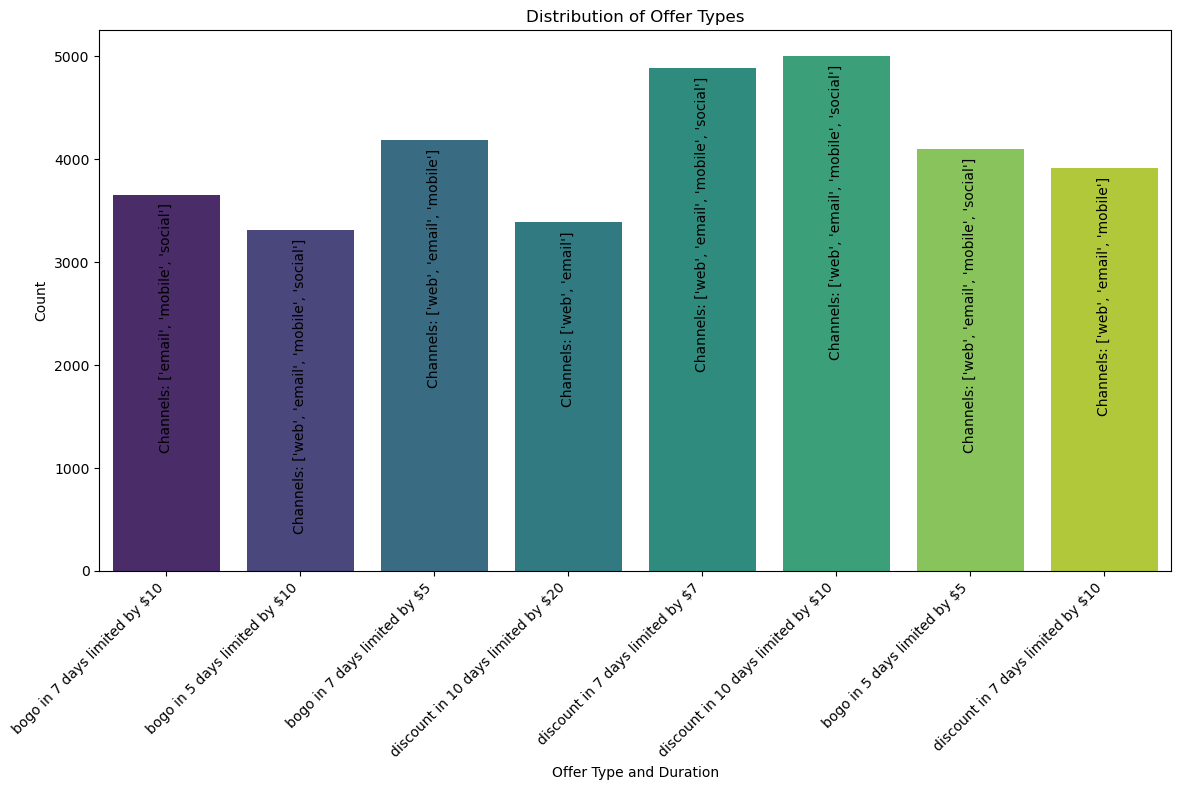

In [387]:

# Step 1: Create x-axis labels by combining 'offer_type', 'duration', and 'difficulty'
count_merged_df['x_axis'] = count_merged_df['offer_type'] + ' in ' + count_merged_df['duration'].astype(str) + ' days limited by $' + count_merged_df['difficulty'].astype(str)

# Filter the DataFrame to only include rows with a non-zero count
filtered_df = count_merged_df[count_merged_df['count'] != 0]

# Step 2: Plotting
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='x_axis', y='count', data=filtered_df, palette='viridis', hue = count_merged_df['x_axis'], legend = False)

# Step 3: Adding channel information to each bar
i= 0
for _, row in filtered_df.iterrows():
    bar_plot.text(i, row['count'], 
                  f"Channels: {row['channels']}  ", 
                  color='black', 
                  ha='center', 
                  va= 'top',
                  rotation=90)
    i = i+1

plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type and Duration')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to make room for the labels
plt.show()

We can tell that the highest completed offer is `discount` with duration and difficulty = **10** through web, email, mobile, and social.

In [388]:
# Assuming 'merged_df' is your dataframe after merging counts with events
# Expand the 'channels' column into multiple columns with binary values

# Step 1: Convert the 'channels' column to a DataFrame with one-hot encoding
channels_df = count_merged_df['channels'].apply(lambda x: pd.Series({ch: 1 for ch in x})).fillna(0).astype(int)

# Step 2: Rename the columns for clarity
channels_df.columns = [f'channel_{col}' for col in channels_df.columns]

# Step 3: Concatenate the expanded 'channels' with the original dataframe
merged_df_expanded = pd.concat([count_merged_df.drop(columns=['channels', 'count']), channels_df], axis=1)
merged_df_expanded

,reward,difficulty,duration,offer_type,id,x_axis,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo in 7 days limited by $10,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo in 5 days limited by $10,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,informational in 4 days limited by $0,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo in 7 days limited by $5,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount in 10 days limited by $20,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,discount in 7 days limited by $7,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount in 10 days limited by $10,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,informational in 3 days limited by $0,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo in 5 days limited by $5,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount in 7 days limited by $10,1,1,0,1


Text(0.5, 1.0, 'Original Transcript Events')

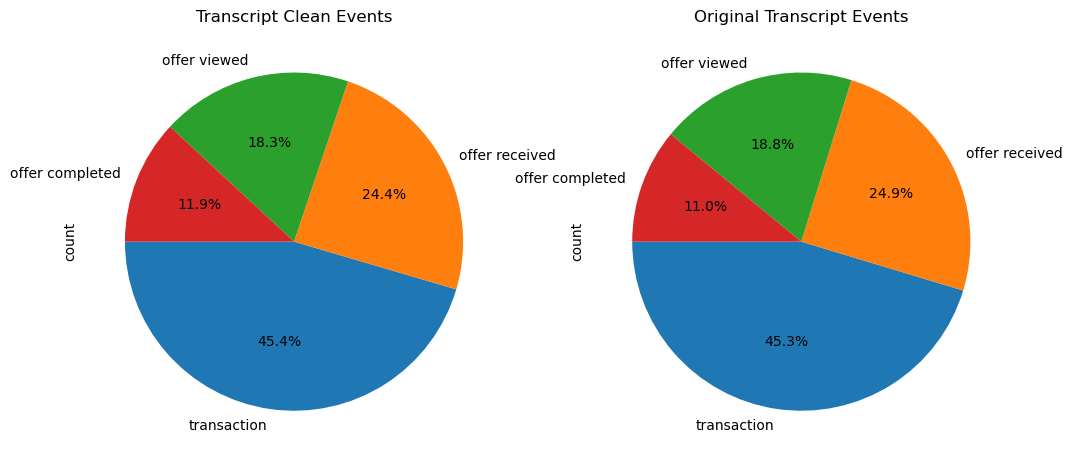

In [389]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

transcript_clean['event'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=180, ax = axes[0])
axes[0].set_title('Transcript Clean Events')  # Title for the first pie chart
transcript['event'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=180, ax = axes[1])
axes[1].set_title('Original Transcript Events')  # Title for the second pie chart

As noticed, the portion of offers completed increased after cleaning some wrong entered data.

In [390]:
# Step 1: Filter the transcript for relevant events and count each event by person
event_counts = (
    transcript_clean[transcript_clean['event'].isin(['offer received', 'offer viewed', 'offer completed', 'transaction'])]
    .groupby(['person', 'event'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 2: Rename columns for clarity
event_counts.columns = ['person', 'offer_received', 'offer_viewed', 'offer_completed', 'transactions']

# Step 3: Merge with profile_clean dataset
profile_clean = profile_clean.merge(event_counts, left_on='id', right_on='person', how='left')

# Step 4: Drop redundant column (if necessary) and fill NaN values with 0 for the new columns
profile_clean.drop(columns=['person'], inplace=True)
profile_clean.fillna(0, inplace=True)

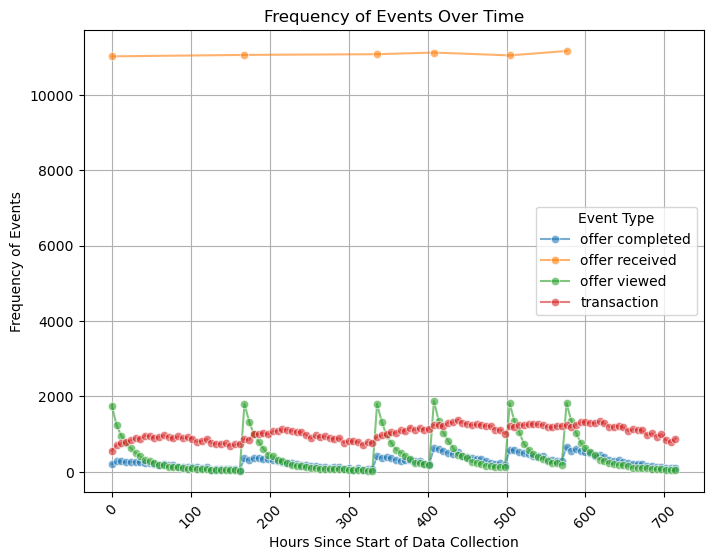

In [397]:
# Group by 'time' and 'event' to get frequency counts
event_counts_over_time = (
    transcript_clean
    .groupby(['time', 'event'])
    .size()
    .reset_index(name='count')
)
plt.figure(figsize=(8, 6))

# Use Seaborn to create a lineplot
sns.lineplot(
    data=event_counts_over_time, 
    x='time', 
    y='count', 
    hue='event', 
    marker='o',
    alpha = 0.6
)

# Customize the plot
plt.title('Frequency of Events Over Time')
plt.xlabel('Hours Since Start of Data Collection')
plt.ylabel('Frequency of Events')
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.grid(True)

# Show the plot
plt.show()

From the figure above, it looks like that almost 2k out of 12k received events are being viewed at the same day.

In [392]:
# Time in days to measure how long does it take to resend offeres
np.sort(transcript_clean[transcript_clean['event'] == 'offer received']['time'].value_counts().index/24)

array([ 0.,  7., 14., 17., 21., 24.])

In [393]:
profile_clean['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

,gender,age,id,became_member_on,income,offer_received,offer_viewed,offer_completed,transactions
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,2,0,3
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3,4,4,7
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2,4,3,3
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,5,6,6,3
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1,3,2,4
...,...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,0,3,3,7
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1,3,1,7
14822,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,0,3,1,8
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,3,3,3,14


## Section : Evaluate the Results Analysis
